In [3]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns

# Load the updated training and test datasets
training_data_path = 'training_data.csv'  # Adjust file path as needed
test_data_path = 'test_data.csv'  # Adjust file path as needed

# Load the datasets
training_data = pd.read_csv(training_data_path)
test_data = pd.read_csv(test_data_path)

# Clean the data: Remove commas from Force columns and convert them to float
training_data['Force (N)'] = training_data['Force (N)'].replace({',': ''}, regex=True).astype(float)
test_data['Predicted Force (N)'] = test_data['Predicted Force (N)'].replace({',': ''}, regex=True).astype(float)

# Manually setting the actual forces for comparison based on the thickness values
actual_forces = [
    25010.32, 25172.46, 25320.78, 20690.14, 20846.25, 20980.45,
    14100.78, 14224.50, 14350.92, 6625.34, 6749.28, 6820.49,
    3989.12, 4090.77, 4150.23, 3150.45, 3237.30, 3302.78
]

# Assign these actual forces to the test data
test_data['Actual Force'] = actual_forces

# Prepare the training data
X_train = training_data[['Density (log transformation)', 'Elasticity (Pa)', 'Tensile Stress (Pa)', 'Thickness (mm)']]
y_train = training_data['Force (N)']

# Prepare the test data
X_test = test_data[['Density (log transformation)', 'Elasticity (Pa)', 'Tensile Stress (Pa)', 'Thickness (mm)']]

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

# Define the Gaussian Process Regressor with an RBF kernel
kernel = C(1.0, (1e-3, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1))

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Hyperparameter grid search
param_grid = {
    'alpha': [1e-2, 1e-3, 1e-4, 1e-5],
    'kernel__k1__k1__constant_value': [0.1, 1, 10, 100],
    'kernel__k1__k2__length_scale': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(gpr, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_poly, y_train)

# Get the best model
best_gpr = grid_search.best_estimator_

# Predict the Force (N) values for the test data
predicted_forces = best_gpr.predict(X_test_poly)

# Add the predicted forces to the test data
test_data['Predicted Force (N)'] = predicted_forces

# Calculate performance metrics
mse = mean_squared_error(test_data['Actual Force'], predicted_forces)
rmse = np.sqrt(mse)
r2 = r2_score(test_data['Actual Force'], predicted_forces)
mae = mean_absolute_error(test_data['Actual Force'], predicted_forces)
mape = np.mean(np.abs((test_data['Actual Force'] - predicted_forces) / test_data['Actual Force'])) * 100
max_error = np.max(np.abs(test_data['Actual Force'] - predicted_forces))

# Print performance metrics
print(f'MSE: {mse}, RMSE: {rmse}, R2: {r2}, MAE: {mae}, MAPE: {mape:.2f}%, Max Error: {max_error}')

# Plot Predicted vs Actual Forces
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Actual Force'], predicted_forces, color='blue', label='Predicted vs Actual')
plt.plot([test_data['Actual Force'].min(), test_data['Actual Force'].max()], [test_data['Actual Force'].min(), test_data['Actual Force'].max()], 'k--', label='Perfect Prediction')
plt.xlabel('Actual Force (N)')
plt.ylabel('Predicted Force (N)')
plt.title('Predicted vs Actual Force')
plt.legend()
plt.show()

# Residual Plot
residuals = test_data['Actual Force'] - predicted_forces
plt.figure(figsize=(10, 6))
plt.scatter(predicted_forces, residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Force (N)')
plt.ylabel('Residuals (N)')
plt.title('Residual Plot')
plt.show()

# Learning Curve
train_sizes, train_scores, validation_scores = learning_curve(best_gpr, X_train_poly, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error', color='blue')
plt.plot(train_sizes, validation_scores_mean, label='Validation error', color='green')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Confidence Intervals Plot
predicted_mean, predicted_std = best_gpr.predict(X_test_poly, return_std=True)
plt.figure(figsize=(10, 6))
plt.plot(test_data['Thickness (mm)'], predicted_forces, 'bo', label='Predicted Force')
plt.fill_between(test_data['Thickness (mm)'], predicted_mean - 1.96 * predicted_std, predicted_mean + 1.96 * predicted_std, color='r', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Thickness (mm)')
plt.ylabel('Force (N)')
plt.title('Prediction with Confidence Intervals')
plt.legend()
plt.show()

# SHAP Summary Plot
explainer = shap.KernelExplainer(best_gpr.predict, X_train_poly[:100])
shap_values = explainer.shap_values(X_test_poly[:100])

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_poly, feature_names=poly.get_feature_names_out())
plt.show()

# Feature Correlation Heatmap
corr_matrix = training_data[['Density (log transformation)', 'Elasticity (Pa)', 'Tensile Stress (Pa)', 'Thickness (mm)', 'Force (N)']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Correlation coefficient'})

# Set the title with the desired font size and bold text
plt.title('Latex', fontsize=22, fontweight='bold')

# Set the x and y labels with desired font size
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Show the plot
plt.show()


KeyboardInterrupt: 

Actual vs Predicted


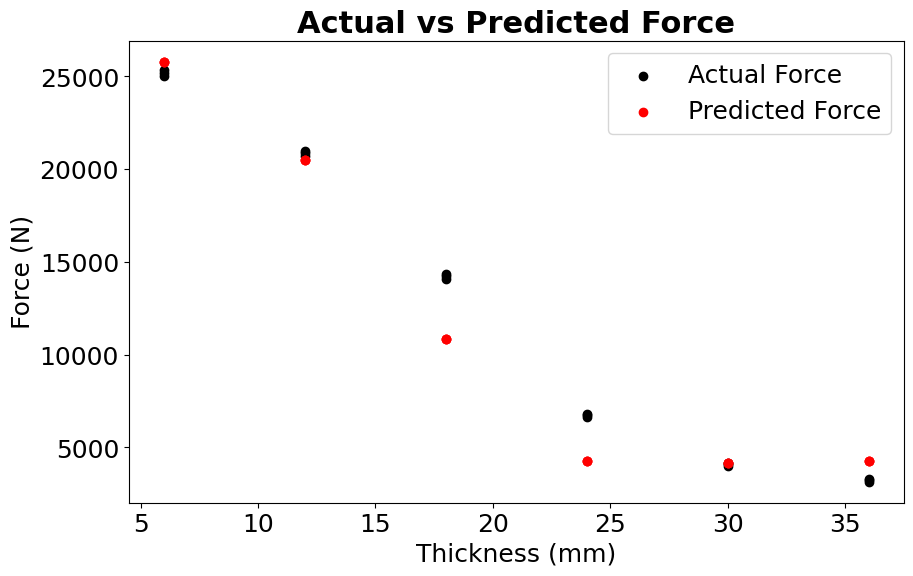

In [ ]:
import matplotlib.pyplot as plt

# Set font properties
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 18

# Plot Actual vs Predicted Forces
plt.figure(figsize=(10, 6))

# Plot Actual Force (black round dot)
plt.scatter(test_data['Thickness (mm)'], test_data['Actual Force'], color='black', label='Actual Force', marker='o')

# Plot Predicted Force (red round dot)
plt.scatter(test_data['Thickness (mm)'], test_data['Predicted Force (N)'], color='red', label='Predicted Force', marker='o')

# Add title and labels
plt.title('Actual vs Predicted Force', fontsize=22, fontweight='bold')  # Title with font size 22 and bold
plt.xlabel('Thickness (mm)', fontsize=18)  # X-axis label with font size 18
plt.ylabel('Force (N)', fontsize=18)  # Y-axis label with font size 18

# Add a legend
plt.legend(fontsize=18)

# Show the plot
plt.show()


Feature Correlation Heatmap

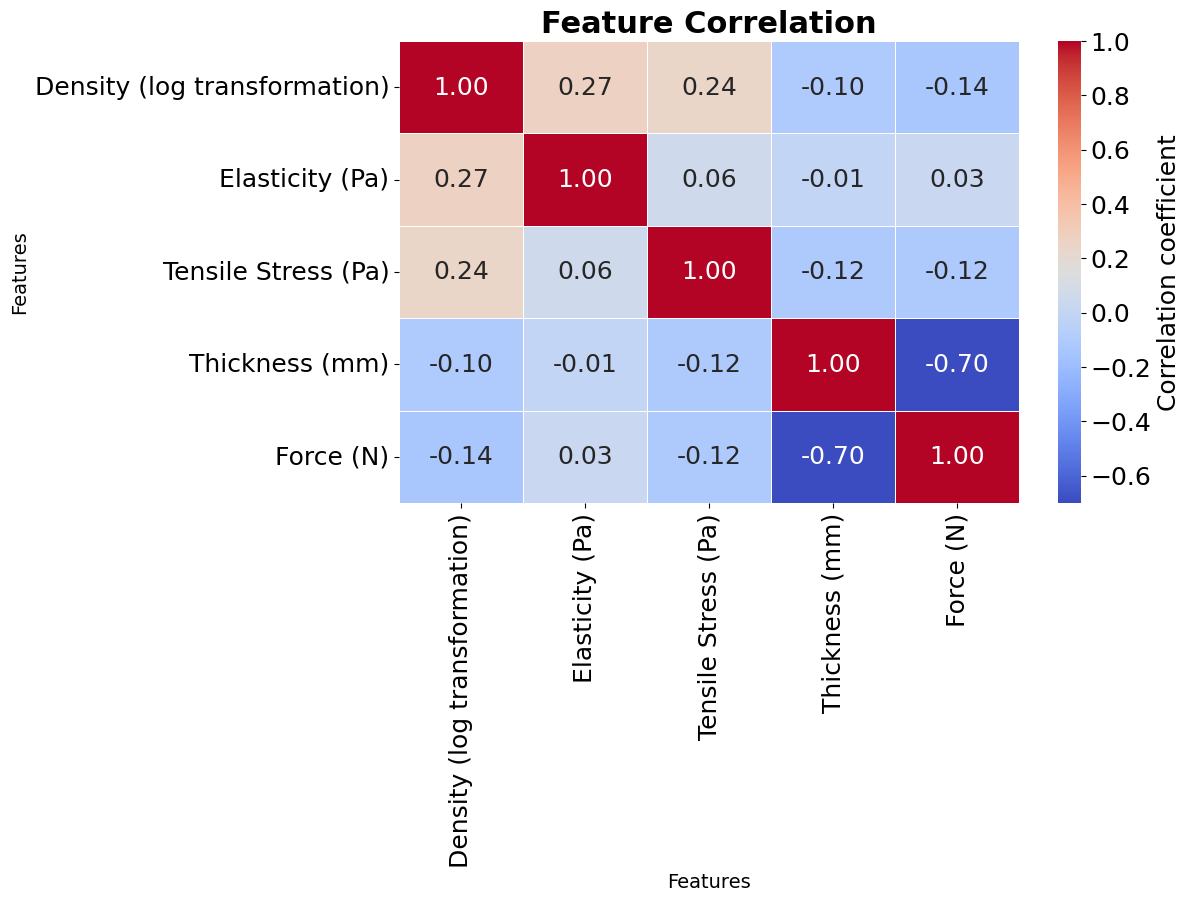

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix of the features
corr_matrix = training_data[['Density (log transformation)', 'Elasticity (Pa)', 'Tensile Stress (Pa)', 'Thickness (mm)', 'Force (N)']].corr()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Correlation coefficient'})

# Set the title with the desired font size and bold text
plt.title('Feature Correlation', fontsize=22, fontweight='bold')

# Set the x and y labels with desired font size
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Show the plot
plt.show()


Residual Plot

In [ ]:
# Residual Plot
residuals = test_data['Actual Force'] - predicted_forces
plt.figure(figsize=(10, 6))
plt.scatter(predicted_forces, residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Force (N)')
plt.ylabel('Residuals (N)')
plt.title('Residual Plot')
plt.show()



Learning Curve

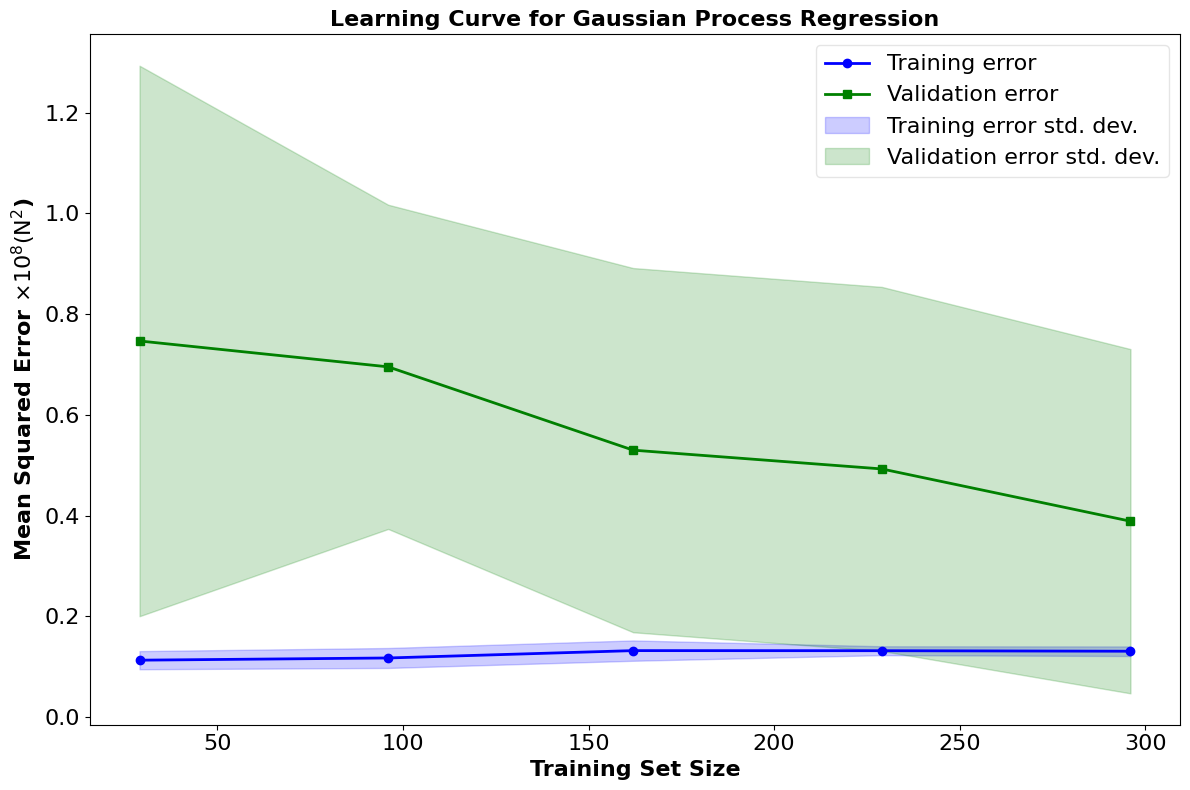

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.patches as mpatches

# Assuming best_gpr, X_train_poly, y_train are defined
train_sizes, train_scores, validation_scores = learning_curve(
    best_gpr, X_train_poly, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1
)

# Compute mean and standard deviation
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
validation_scores_std = validation_scores.std(axis=1)

# Define scaling factor to replace 1e8
scale = 1e8

# Create the enhanced plot
plt.figure(figsize=(12, 8))

# Plot training error with standard deviation shading, scaled
plt.plot(train_sizes, train_scores_mean / scale, label='Training error', color='blue', linewidth=2, marker='o')
plt.fill_between(
    train_sizes,
    (train_scores_mean - train_scores_std) / scale,
    (train_scores_mean + train_scores_std) / scale,
    color='blue',
    alpha=0.2
)

# Plot validation error with standard deviation shading, scaled
plt.plot(train_sizes, validation_scores_mean / scale, label='Validation error', color='green', linewidth=2, marker='s')
plt.fill_between(
    train_sizes,
    (validation_scores_mean - validation_scores_std) / scale,
    (validation_scores_mean + validation_scores_std) / scale,
    color='green',
    alpha=0.2
)

# Customize labels and title with font size 16, bold
plt.xlabel('Training Set Size', fontsize=16, fontweight='bold')
plt.ylabel(r'Mean Squared Error $\times 10^8 (\mathrm{N}^2$)', fontsize=16, fontweight='bold')
plt.title('Learning Curve for Gaussian Process Regression', fontsize=16, fontweight='bold')

# Set tick font size to 16
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Create dummy patches for legend to represent shaded areas
train_shade = mpatches.Patch(color='blue', alpha=0.2, label='Training error std. dev.')
val_shade = mpatches.Patch(color='green', alpha=0.2, label='Validation error std. dev.')

# Get handles and labels for the plotted lines
handles, labels = plt.gca().get_legend_handles_labels()

# Add the dummy patches to the handles
handles.extend([train_shade, val_shade])

# Enhance the legend with font size 16 and include shaded area descriptions
plt.legend(handles=handles, loc='best', fancybox=True, framealpha=0.5, fontsize=16)

# Ensure no grids are displayed
plt.grid(False)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()